<center> 

# Customer Churn EDA <br> 

</center>

In [1]:
# Installing dependencies via requirements.txt 
#%pip install -r ../requirements.txt 


In [30]:
# Importing libraries
import warnings 
warnings.filterwarnings('ignore') 

import sys 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from pathlib import Path 

# Getting the project root 
project_root = Path().resolve().parent 
sys.path.append(str(project_root)) 

# src/utils.py 
from src.utils import data_path, visuals_path, save_data, group_churn 
from src.feature_engineering import clean_column_names 



In [6]:
# Setting random_state for reproducibility 
random_state = 42 
np.random.seed(random_state)


In [7]:
# Plotting settings 
sns.set_style('whitegrid') 
plt.rcParams['figure.figsize'] = (10,6) 


In [8]:
# Loading data 
telco_data_path = data_path / "telco_churn_data.csv" 

telco_data = pd.read_csv(telco_data_path) 
telco_data.head() 
print("\nData Info: ") 
print(telco_data.info()) 



Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-nu

In [17]:
data = telco_data.copy() 

# Data checks 
print("\nMissing values: ") 
print(data.isna().sum()) 

# Checking if there are duplicate customerID values 
print("\nAll unique customerID --> ", data['customerID'].nunique() == len(data)) 



Missing values: 
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

All unique customerID -->  True


In [18]:
# Cleaning column names 
data = clean_column_names(data) 
# Converting TotalCharges to numeric 
if data['totalcharges'].dtype == 'object': 
    data['totalcharges'] = pd.to_numeric(data['totalcharges'], errors='coerce') 
    print("\nTotalCharges NA count (After numeric conversion): ", data['totalcharges'].isna().sum())

# Checking if any rows have tenure == 0 & totalcharges == NaN 
# Possible for new customers 
new_cust = (data['tenure'] == 0) & (data['totalcharges'].isna()) 
print("\nRows with tenure == 0 & totalcharges == NaN : ", new_cust.sum()) 



TotalCharges NA count (After numeric conversion):  11

Rows with tenure == 0 & totalcharges == NaN :  11


In [20]:
# Changing TotalCharges to 0 if tenure==0 (Assumed it is a new customer) 
# If any TotalCharges==NaN remain these will be handled later 
data.loc[(data['tenure']==0) & (data['totalcharges'].isna()), 'totalcharges'] = 0.0 
print("Remaining NaN TotalCharges values after fix: ", data['totalcharges'].isna().sum()) 


Remaining NaN TotalCharges values after fix:  0


In [23]:
# Encoding the SeniorCitizen column to match the other columns (converting 0/1 to labels) 
data['seniorcitizen'] = data['seniorcitizen'].map({0:'No', 1:'Yes'}) 
print(data['seniorcitizen'].head())


0    No
1    No
2    No
3    No
4    No
Name: seniorcitizen, dtype: object


In [11]:
# Saving cleaned data to Data/ folder 
#save_data(data, "cleaned_raw_data") 


<center> 

### Exploratory Data Analysis (EDA) <br> 
Looking at group churn rates, population comparisons, visualizations, and interpretations 

</center>

In [34]:
# Finding baseline churn rate (Total churn rate) 
print("Baseline churn:") 
print(data['churn'].value_counts(normalize=True)) 


Baseline churn:
churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


<center> 

**Baseline Churn Rate: 26.54%** 

</center> 

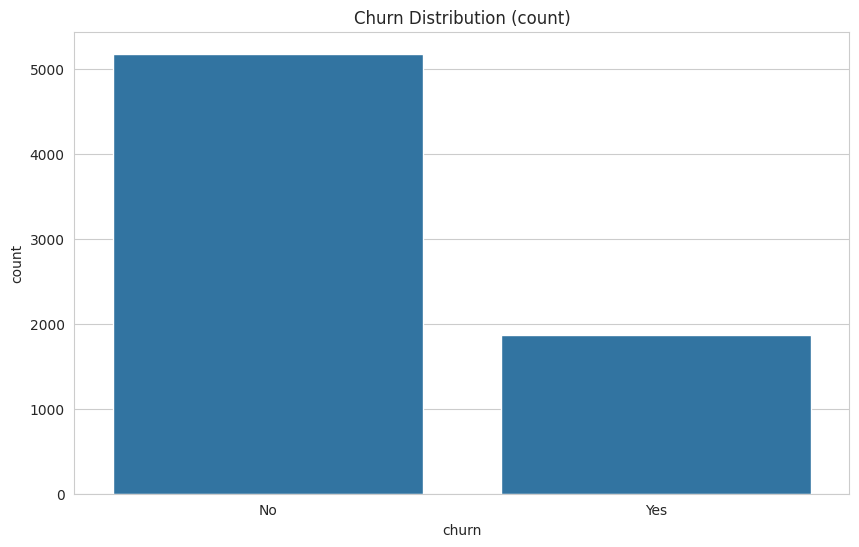

In [35]:
# Churn distribution 
ax = sns.countplot(x='churn', data=data) 
ax.set_title("Churn Distribution (count)") 
#plt.savefig(visuals_path / 'churn_distribution.png', dpi=150, bbox_inches='tight') 
plt.show() 


In [36]:
# Calculating cross-tabs for seniorcitizen 
# Adding calculations to separate Senior/Non-Senior 
senior_crosstab = pd.crosstab(data['seniorcitizen'], data['churn'], normalize=True, margins=True) 
senior_crosstab = senior_crosstab.rename(columns={'No':'churn_no_pct', 'Yes':'churn_yes_pct'})
print("Senior Citizen cross-tabulation: ") 
senior_crosstab

Senior Citizen cross-tabulation: 


churn,churn_no_pct,churn_yes_pct,All
seniorcitizen,,,
No,0.640068,0.197785,0.837853
Yes,0.094562,0.067585,0.162147
All,0.734630,0.265370,1.000000


In [37]:
# Calculating spearate percentages for senior/non-senior 
senior_churn = senior_crosstab.loc['Yes','churn_yes_pct'] if 'Yes' in senior_crosstab.index else None 
non_senior_churn = senior_crosstab.loc['No','churn_yes_pct'] 
print("Senior (in-group) Churn (Yes): ", senior_churn) 
print("\nNon-Senior (in-group) Churn (Yes): ", non_senior_churn) 



Senior (in-group) Churn (Yes):  0.06758483600738321

Non-Senior (in-group) Churn (Yes):  0.19778503478631265


**Note:** <br>
Senior citizens had a population churn rate of 6.76%, however, looking at in-group rates senior citizens had a much higher churn rate of 41.68% compared to non-senior citizens in-group churn rate of 23.61%.  
Despite senior citizens having the higher in-group churn rate, non-senior citizens still had a much higher population churn share (19.78%). 

In [38]:
# Contract type and churn 
contract_stats = group_churn(data, 'contract') 
print(contract_stats[['group_churn','population_share','population_churn_share']]) 
# Bar plot 
ax = contract_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate (P(Churn=Yes | Contract))') 
ax.set_title('Churn by Contract Type (in-group)') 
plt.xticks(rotation=0) 
# Saving figure 
#plt.savefig(visuals_path / 'churn_by_contract.png', dpi=150, bbox_inches='tight') 
plt.show() 


KeyError: 'Churn'

In [ ]:
# Internet service and churn 
InternetService_stats = group_churn(data, 'internetservice') 
print(InternetService_stats[['group_churn','population_share','population_churn_share']]) 
# Bar plot 
ax = InternetService_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Internet Service') 
plt.xticks(rotation=0) 
# Saving figure 
#plt.savefig(visuals_path / 'churn_by_internet_service.png', dpi=150, bbox_inches='tight') 
plt.show() 


In [ ]:
# Gender and churn 
gender_stats = group_churn(data, 'gender') 
print(gender_stats[['group_churn','population_share','population_churn_share']]) 
# Bar plot 
ax = gender_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Gender Service') 
plt.xticks(rotation=0) 
# Saving figure 
#plt.savefig(visuals_path / 'churn_by_gender.png', dpi=150, bbox_inches='tight') 
plt.show() 


In [ ]:
# Partner and churn 
partner_stats = group_churn(data, 'partner') 
print(partner_stats[['group_churn','population_share','population_churn_share']]) 
# Bar plot 
ax = partner_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Partner (has partner - Yes/No)') 
plt.xticks(rotation=0) 
# Saving figure 
#plt.savefig(visuals_path / 'churn_by_partner.png', dpi=150, bbox_inches='tight') 
plt.show() 


In [ ]:
# Dependents and churn 
dependents_stats = group_churn(data, 'dependents') 
print(dependents_stats[['group_churn','population_share','population_churn_share']]) 
# Bar Plot 
ax = dependents_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Dependents (has dependents)') 
plt.xticks(rotation=0) 
# Saving figure 
#plt.savefig(visuals_path / 'churn_by_dependents.png', dpi=150, bbox_inches='tight') 
plt.show()


In [ ]:
# Phone service and churn 
PhoneService_stats = group_churn(data, 'phoneservice') 
print(PhoneService_stats[['group_churn','population_share','population_churn_share']]) 
# Bar Plot 
ax = PhoneService_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Phone Service') 
plt.xticks(rotation=0) 
# Saving figure 
#plt.savefig(visuals_path / 'churn_by_phone_service.png', dpi=150, bbox_inches='tight') 
plt.show()


In [ ]:
# Multiple lines and churn 
MultipleLines_stats = group_churn(data, 'multiplelines') 
print(MultipleLines_stats[['group_churn','population_share','population_churn_share']]) 
# Bar Plot 
ax = MultipleLines_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Multiple Lines') 
plt.xticks(rotation=0) 
# Saving figure 
#plt.savefig(visuals_path / 'churn_by_multiple_lines.png', dpi=150, bbox_inches='tight') 
plt.show()


In [ ]:
# Online security and churn 
OnlineSecurity_stats = group_churn(data, 'onlinesecurity') 
print(OnlineSecurity_stats[['group_churn','population_share','population_churn_share']]) 
# Bar Plot 
ax = OnlineSecurity_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Online Security') 
plt.xticks(rotation=0) 
# Saving figure 
#plt.savefig(visuals_path / 'churn_by_online_security.png', dpi=150, bbox_inches='tight') 
plt.show()


In [ ]:
# Online backup and churn 
OnlineBackup_stats = group_churn(data, 'onlinebackup') 
print(OnlineBackup_stats[['group_churn','population_share','population_churn_share']]) 
# Bar Plot 
ax = OnlineBackup_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Online Backup') 
plt.xticks(rotation=0) 
# Saving figure 
#plt.savefig(visuals_path / 'churn_by_online_backup.png', dpi=150, bbox_inches='tight') 
plt.show()


In [ ]:
# Device protection and churn 
DeviceProtection_stats = group_churn(data, 'deviceprotection') 
print(DeviceProtection_stats[['group_churn','population_share','population_churn_share']]) 
# Bar Plot 
ax = DeviceProtection_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Device Projection') 
plt.xticks(rotation=0) 
# Saving figure 
#plt.savefig(visuals_path / 'churn_by_device_protection.png', dpi=150, bbox_inches='tight') 
plt.show()


In [ ]:
# Tech support and churn 
TechSupport_stats = group_churn(data, 'techsupport') 
print(TechSupport_stats[['group_churn','population_share','population_churn_share']]) 
# Bar Plot 
ax = TechSupport_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Tech Support') 
plt.xticks(rotation=0) 
# Saving figure 
#plt.savefig(visuals_path / 'churn_by_tech_support.png', dpi=150, bbox_inches='tight') 
plt.show()


In [ ]:
# Streaming TV and churn 
StreamingTV_stats = group_churn(data, 'streamingtv') 
print(StreamingTV_stats[['group_churn','population_share','population_churn_share']]) 
# Bar Plot 
ax = StreamingTV_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Streaming TV') 
plt.xticks(rotation=0) 
# Saving figure 
#plt.savefig(visuals_path / 'churn_by_streaming_tv.png', dpi=150, bbox_inches='tight') 
plt.show()


In [ ]:
# Streaming movies and churn 
StreamingMovies_stats = group_churn(data, 'streamingmovies') 
print(StreamingMovies_stats[['group_churn','population_share','population_churn_share']]) 
# Bar Plot 
ax = StreamingMovies_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Streaming Movies') 
plt.xticks(rotation=0) 
# Saving figure 
#plt.savefig(visuals_path / 'churn_by_streaming_movies.png', dpi=150, bbox_inches='tight') 
plt.show()


In [ ]:
# Paperless billing and churn 
PaperlessBilling_stats = group_churn(data, 'paperlessbilling') 
print(PaperlessBilling_stats[['group_churn','population_share','population_churn_share']]) 
# Bar Plot 
ax = PaperlessBilling_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Paperless Billing') 
plt.xticks(rotation=0) 
# Saving figure 
#plt.savefig(visuals_path / 'churn_by_paperless_billing.png', dpi=150, bbox_inches='tight') 
plt.show()


In [ ]:
# Payment method and churn 
PaymentMethod_stats = group_churn(data, 'paymentmethod') 
print(PaymentMethod_stats[['group_churn','population_share','population_churn_share']]) 
# Bar Plot 
ax = PaymentMethod_stats['group_churn'].plot(kind='bar') 
ax.set_ylabel('In-Group Churn Rate') 
ax.set_title('Churn by Payment Method') 
plt.xticks(rotation=0) 
# Saving figure 
#plt.savefig(visuals_path / 'churn_by_payment_method.png', dpi=150, bbox_inches='tight') 
plt.show()


In [ ]:
# Plotting Histplot and KDE for numerical columns (tenure, MonthlyCharges, TotalCharges) 
numeric_columns = ['tenure','monthlycharges','totalcharges'] 
for col in numeric_columns: 
    sns.histplot(data[data['churn'] == "Yes"][col], color='red', kde=True) 
    sns.histplot(data[data['churn'] == "No"][col], color='green', kde=True) 
    plt.title(f"{col} + Churn (Histplot/KDE)")
    #plt.savefig(visuals_path / f'histplot_kde_{col}_by_churn.png', dpi=150, bbox_inches='tight')  
    plt.show()


In [ ]:
# Plotting boxplots for numerical columns (tenure, MonthlyCharges, TotalCharges) 
numeric_columns = ['tenure','monthlycharges','totalcharges'] 
for col in numeric_columns: 
    plt.figure(figsize=(9,4)) 
    sns.boxplot(x='churn', y=col, data=data) 
    plt.title(f'{col} by Churn') 
    #plt.savefig(visuals_path / f'boxplot_{col}_by_churn.png', dpi=150, bbox_inches='tight') 
    plt.show() 


In [ ]:
# Plotting violin plots for numerical columns (tenure, MonthlyCharges, TotalCharges) 
numeric_columns = ['tenure','monthlycharges','totalcharges'] 
for col in numeric_columns: 
    plt.figure(figsize=(9,4)) 
    sns.violinplot(x='churn', y=col, data=data, inner='quartile') 
    plt.title(f'{col} distribution by Churn') 
    #plt.savefig(visuals_path / f'violinplot_{col}_by_churn.png', dpi=150, bbox_inches='tight') 
    plt.show() 


In [ ]:
# Encoding categorical variables for correlation analysis 
# Using target encoding to show mean churn rate (instead of label encoding) 
corr_df = data.copy() 
# Function to encode categorical variables (except customerID) 
def target_encoding(data, target_column, exclude_columns=None): 
    if exclude_columns is None: 
        exclude_columns = [] 

    encoded_df = data.copy() 
    # Encoding target variable (Churn) 
    if encoded_df[target_column].dtype == 'object': 
        unique_values = encoded_df[target_column].unique() 
        if len(unique_values) == 2: 
            mapping = {unique_values[0]: 0, unique_values[1]: 1} 
            encoded_df[target_column] = encoded_df[target_column].map(mapping) 

    # Encoding categorical variables (except customerID) 
    for col in encoded_df.select_dtypes(include='object').columns: 
        if col not in exclude_columns: 
            means = encoded_df.groupby(col)[target_column].mean() 
            encoded_df[col] = encoded_df[col].map(means) 

    return encoded_df 


encoded_df = target_encoding(corr_df, target_column='churn', exclude_columns=['customerid']) 
# Dropping customerID column from encoded_df 
encoded_df = encoded_df.drop(columns=['customerid']) 
print(encoded_df.info()) 


In [ ]:
# Correlation Matrix (by Churn) 
encoded_corr = encoded_df.corr()['churn'].sort_values(ascending=False) 
encoded_corr 


In [ ]:
# Plotting heatmap of correlation matrix 
plt.figure(figsize=(6, 10)) 
sns.heatmap(encoded_corr.to_frame(), annot=True, fmt=".2f", cmap='coolwarm', center=0) 
plt.title("Correlation Heatmap") 
#plt.savefig(visuals_path / 'target_encoded_corr_matrix_target_grouping.png', dpi=150, bbox_inches='tight')
plt.show() 


In [ ]:
# Plotting full correlation matrix 
full_corr = encoded_df.corr() 
# Plotting heatmap of correlation matrix 
plt.figure(figsize=(12, 10)) 
sns.heatmap(full_corr, annot=True, fmt=".2f", cmap='coolwarm', center=0) 
plt.title("Correlation Heatmap") 
#plt.savefig(visuals_path / 'target_encoded_full_corr_matrix.png', dpi=150, bbox_inches='tight')
plt.show() 


In [ ]:
# Encoding using different method 
corr_data = data.copy() 
# Mapping binary Yes/No (and some other categorical values) to numeric 
binary_mapping = {'Yes':1, 'No':0, 'No phone service':0, 'No internet service':0} 
columns_to_map = ['seniorcitizen','partner','dependents','phoneservice','multiplelines','onlinesecurity','onlinebackup',
                  'deviceprotection','techsupport','streamingtv','streamingmovies','paperlessbilling']

for c in columns_to_map: 
    if c in corr_data.columns: 
        corr_data[c] = corr_data[c].map(binary_mapping).fillna(corr_data[c]) 

# Mapping 'Churn' 
corr_data['churn'] = corr_data['churn'].map({'Yes':1, 'No':0}) 

# Encoding other categorical strings ordinally 
ordinal_mapping = {
    'internetservice': {'No':0, 'DSL':1, 'Fiber optic':2}, 
    'contract': {'Month-to-month':0, 'One year':1, 'Two year':2}, 
    'paymentmethod': {'Electronic check':0, 'Mailed check':1, 'Bank transfer (automatic)':2, 'Credit card (automatic)':3}
}

for c, m in ordinal_mapping.items(): 
    if c in corr_data.columns: 
        corr_data[c] = corr_data[c].map(m) 


In [ ]:
corr_matrix = corr_data.select_dtypes(include=[np.number]).corr() 
corr_matrix 


In [ ]:
# Plotting correlation heatmap 
plt.figure(figsize=(12, 10)) 
sns.heatmap(corr_matrix, cmap='RdBu_r', center=0, annot=True, fmt=".2f") 
plt.title('Full Correlation Matrix (numeric-encoded)') 
#plt.savefig(visuals_path / 'numeric_encoded_full_corr_matrix.png', dpi=150, bbox_inches='tight')
plt.show() 


In [ ]:
# Plotting interaction (tenure vs MonthlyCharges) colored by Churn 
plt.figure(figsize=(9,6)) 
# Using alpha so dense regions are shown 
sns.scatterplot(x='tenure', y='monthlycharges', hue='churn', data=data, alpha=0.6) 
plt.title("Tenure vs MonthlyCharges colored by Churn") 
#plt.savefig(visuals_path / 'tenure_vs_monthlycharges_churn.png', dpi=150, bbox_inches='tight')
plt.show()
